<div>
<img src="images/cosimpy_logo.png" width="250" align="center"/>
</div>

# <center> ISMRM 2022 DEMO

<div>
<img src="images/setup.png" width="500" align="left"/>
</div>

PRELIMINARY ASSUMPTIONS:
1. A 7-port full-wave simulation has been performed with *Sim4Life*;
2. The S parameters (f = 128 MHz +/- 60 MHz), obtained from the 7-port full-wave simulation, are saved according to the Touchstone file format specifications Rev. 1.1 provided by the IBIS Open Forum. The Touchstone file is saved in the same directory of the Python script and named "s_param.s7p";
3. A directory named “Field” is created in the same directory of the Python script. Inside the “Field” directory, the electromagnetic field distributions, generated by 1 W power incident to each of the seven ports of the simulated device at 128 MHz, are stored. Each file is named “b(e)field_port\<n>.mat”, where “b” and “e” are used for magnetic and electric field distributions respectively and “\<n>” denotes the port number (ranging, for the relevant case, from 1 to 7). These files can be automatically exported by *Sim4Life* on an isotropic Cartesian grid;

<div>
<img src="images/em_field_folder.png" width="350" align="center"/>
</div>

4. Version 1.4.0 (this version will be available after ISMRM 2022) of CoSimPy is installed.

### CODE:

In [4]:
import cosimpy

Import of the Touchstone file containing the S parameters:

In [5]:
s_matrix = cosimpy.S_Matrix.importTouchstone(".//s_param.s7p")

print(s_matrix)

"""""""""""""""
   S MATRIX
"""""""""""""""

|V-| = |S||V+|
|7 x 1| = |7 x 7||7 x 1|

Number of frequency values = 5001




Import of the EM fields from the ".mat" files exported from *Sim4Life*:

In [6]:
em_field = cosimpy.EM_Field.importFields_s4l(".//Field", freqs=[128e6], nPorts=7)

print("\n")
print(em_field)

Importing port7 fields

"""""""""""""""
   EM FIELD
"""""""""""""""

Number of frequency values = 1
Number of ports = 7
Number of point (nx, ny, nz) = 85, 45, 100




*New in version 1.4.0*

Setting of the domain pysical properties (*i.e.* electrical conductivity).

* "idxs": nx\*ny*nz array of integers where idxs[n] represents the index of the n-th voxel:
    - 0: Air
    - 1: Phantom
* "el_cond": array with lenght equal to (1 + max(idxs)) where max(idxs) is the maximum index contained in the "idxs" array

In [7]:
import numpy as np

idxs = np.ones(np.prod(em_field.nPoints))

# From Sim4Life, I used a mask to set as NaN the EM field outside of the phantom.
# Therefore, where the EM field is NaN, the voxels are Air
idxs[np.isnan(em_field.e_field[0,0,0,:])] = 0

el_cond = [0, 0.47] # Phantom electrical condctivity is equal to 0.47 S/m

em_field.addProperty("idxs", idxs) # "idxs" key is mandatory and has to be added before any other property
em_field.addProperty("el_cond", el_cond) # "el_cond" key is arbitrary

print(em_field)

"""""""""""""""
   EM FIELD
"""""""""""""""

Number of frequency values = 1
Number of ports = 7
Number of point (nx, ny, nz) = 85, 45, 100

'el_cond' additional property defined



Plot of the electrical conductivity over the xy plane to check if everything has been set up correctly:

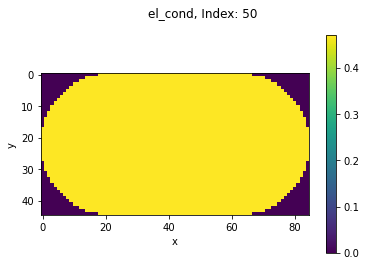

In [8]:
fig = em_field.plotProperty(prop_key="el_cond", plane='xy', sliceIdx=50)

Definition of the *RF_Coil* instance:

In [9]:
rf_coil = cosimpy.RF_Coil(s_matrix, em_field)

print(rf_coil)

       """""""""""""""
           RF COIL
       """""""""""""""


"""""""""""""""
   S MATRIX
"""""""""""""""

|V-| = |S||V+|
|7 x 1| = |7 x 7||7 x 1|

Number of frequency values = 5001

"""""""""""""""
   EM FIELD
"""""""""""""""

Number of frequency values = 1

Number of points = (85, 45, 100)




From previous optimisation routines, considering R = 1 $\Omega$, the following optimum capacitor values have been obtained:
* C<sub>t</sub> = 22.5 pF
* C<sub>d</sub> = 41 pF
* C<sub>m1</sub> = 240 pF
* C<sub>m2</sub> = 38 pF

In [10]:
r = 1 # ohm
ct = 22.5e-12 # farad
cd = 41e-12 # farad
cm1 = 240e-12 # farad
cm2 = 38e-12 # farad

Definition of the external circuitries as *S_Matrix* instances:

In [ ]:
freqs = s_matrix.frequencies
sct = cosimpy.S_Matrix.sMatrixRCseries(r, ct, freqs)
scd = cosimpy.S_Matrix.sMatrixRCseries(0, cd, freqs)
scm1 = cosimpy.S_Matrix.sMatrixRCseries(r, cm1, freqs)
scm2 = cosimpy.S_Matrix.sMatrixRCseries(0, cm2, freqs)

The matching circuit requires a further operation since a 2-port circuit is needed.

<div>
<img src="images/matching_netw.png" width="500" align="center"/>
</div>

I can create the matching circuit from a PI circuit:

In [ ]:
sm = cosimpy.S_Matrix.sMatrixPInetwork(None, scm2, scm1)

Connection of the 7-port RF coil with the external circuitry:

<div>
<img src="images/rf_coil.png" width="400" align="center"/>
</div>

In [ ]:
ext_circ = [sm, sct, sct, sm, scd, sct, sct]

rf_coil_conn = rf_coil.singlePortConnRFcoil(ext_circ, comp_Pinc=True)

print(rf_coil_conn)

Plot of the S parameters of the optimised RF coil:

In [ ]:
fig = rf_coil_conn.s_matrix.plotS(["S1-1", "S2-2", "S1-2"])

Plot of the B<sub>1</sub><sup>+</sup> generated by 1 W of power incident to each port of the optimised RF coil (NOTE: the "plotEMField" method of the *EM_Field* class will be available in version 1.4.0, for previous versions use the "plotB" or "plotE" methods):

In [ ]:
fig = rf_coil_conn.em_field.plotEMField("b_field", comp="b1+", freq=128e6, ports=[1,2], plane='xy', sliceIdx=50, vmin=0, vmax=1.5)

Power balance computation:

In [ ]:
vox_side = 4e-3 # meters
pb = rf_coil_conn.powerBalance(p_inc=[1,1j], voxVols=vox_side**3, elCond_key="el_cond", printReport=True)